In [2]:
#Run this cell to set up imports

from IPython.display import display, Math
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma2ma

# STAT 153: Time Series Homework Five
## Due by 11:59 pm on 28 April 2025

# Scoring Breakdown (Undergraduate)
|Question|Points|
|---|---|
|1a|2|
|1b|3|
|1c|3|
|2a|3|
|2b|4|
|2c|4|
|3a|2|
|3b|2|
|4a|3|
|4b|3|
|5a|2|
|5b|2|
|5c|2|
|6a|3|
|6b|3|
|6c|6|
|6d|3|
|7a|4|
|7b|4|
|7c|4|
|7d|6|
|7e|4|
|8|10|
|9|10|
|**Total**|92|

## 1a)

In order to check for stationarity, we can compute the mean $\mathbb{E}[x_t]$:
$$\mathbb{E}[x_t] = \mathbb{E}[(a + bt)\alpha_t + y_t] = (a + bt)\alpha_t + \mathbb{E}[y_t]$$

Since $y_t$ is stationary, $\mathbb{E}[y_t]$ is constant. Thus:
$$\mathbb{E}[x_t] = (a + bt)\alpha_t + \text{constant}$$

If we examine the first term we can see:

$(a + bt)$ depends on $t$ because of the $bt$ term. $\alpha_t$ is periodic, but when its multiplied by a linearly growing $bt$, it becomes non-periodic. Thus, the mean $\mathbb{E}[x_t]$ depends on time $t$ and changes over time. This means the mean is not constant and therefore the model is not stationary

## 1b)

We are given:
$$\mu_t= \nabla^2_s x_t$$

We can rewrite this as:

$$x_t - 2x_{t-s} + x_{t-2s} \quad \text{where}: x_t = (a + bt)\alpha_t + y_t$$ 

Recall, $\alpha_t$ is periodic with period $s$. Expanding each term:

$$x_t= (a + bt) \alpha_t + y_t$$
$$x_{t-s}=(a + b(t-s))\alpha_t + y_{t-s}$$
$$x_{t-2s}= ( a+b(t- 2s))\alpha_t + y_{t-2s}$$
Substituting into $\mu_t$:
$$\mu_t = [(a+bt) - 2(a + b(t-s)) + (a+b(t-2s))]\alpha_t + (y_t -2y_{t-s} + y_{t-2s})$$

Simplifying the $\alpha_t$:

$$(a+by) - 2(a+b(t-s)) + (a+b(t-2s)) = a+bt-2a -2b(t-s) + a + b(t-2ts) = (a-2a+a)+(bt - 2bt+2bs+bt-2bs)=0$$

Thus:

$$\mu_t = y_t - 2y_{t-s} + y_{t-2s}$$

Since, $y_t$ is stationary by assumption, and stationarity is preserved under finite shifts and linear combinations, it follows that $\mu_t$ is stationary.

## 1c)

In order to write the AutoCovariance function (ACF) of {$\mu_t$} in terms of $\gamma_y (h)$ we want to express $\gamma_u (h) = \text{Cov} (\mu_t , \mu_{t+h}) \, \, \text{using} \, \, \gamma_y (h)$

Recall from part b):
$$u_t = y_t - 2y_{t-s} + y_{t-2s}$$

Exapanding $u_{t+h}$:

$$u_{t+h} = y_{t+h} - 2 y_{t+h-s} + y_{t + h -2s}$$

Thus:

$$\gamma_u (h) = \text{Cov} (y_t - 2y_{t-s} + y_{t-2s}, y_{t+h} - 2y_{t+h-s} + y_{t+h-2s}$$

Now, expanding using the bilinearity of covariance:

$$\gamma_u (h) = \text{Cov}(y_t, y_{t+h}) - 2\text{Cov} (y_t, y_{t+h-s})  + \text{Cov}(y_t, y_{t+h-2s}) - 2\text{Cov} (y_{t-s}, y_{t+h}) + 4\text{Cov}(y_{t-s}, y_{t+h-s}) - 2\text{Cov} (y_{t-s}, y_{t+h-2s}) + \text{Cov}(y_{t-2s}, y_{t+h}) - 2\text{Cov}(y_{t-2s}, y_{t+h-s}) + \text{Cov}(y_{t-2s}, y_{t+h-2s})$$

Expressing each Covariance in terms of $\gamma_y(h)$:

Because $y_t$ is stationary:

-$\text{Cov}(y_t, y_{t+h}) = \gamma_y(h)$

-$\text{Cov}(y_t, y_{t+h-s}) = \gamma_y(h-s)$

-$\text{Cov}(y_t, y_{t+h-2s}) = \gamma_y(h-2s)$

-$\text{Cov}(y_{t-s}, y_{t+h}) = \gamma_y(h+s)$

-$\text{Cov}(y_{t-s}, y_{t+h-s}) = \gamma_y(h)$

-$\text{Cov}(y_{t-s}, y_{t+h-2s}) = \gamma_y(h-s)$

-$\text{Cov}(y_{t-2s}, y_{t+h}) = \gamma_y(h+2s)$

-$\text{Cov}(y_{t-2s}, y_{t+h-s}) = \gamma_y(h+s)$

-$\text{Cov}(y_{t-2s}, y_{t+h-2s}) = \gamma_y({h})$

Substituting back into the original expression:

$$\gamma_u(h) = \gamma_y(h) - 2 \gamma_y(h-s) + \gamma_y(h -2s) -2\gamma_y(h+s) + 4\gamma_y(h) - 2\gamma_y(h-s) + \gamma_y(h+ 2s) - 2\gamma_y(h+s) + \gamma_y(h)$$

Grouping like terms results in:

$$\gamma_u(h) = 6 \gamma_y(h) - 4\gamma_y(h-s) -4\gamma_y(h+s)+ \gamma_y(h-2s) + \gamma (h+2s)$$

## 2a)

Given the AR(2) equation. We can rewrite it as a characteristic polynomial. First, rewriting the model using backshift notation:

$$(1-0.75B + 0.125B^2)y_t = \epsilon_t$$

Thus, the characteristic polynomial is:

$$\phi(z)= 1 - 0.75z + 0.125z^2$$

We can solve the roots of this expression. If we rearrange the expression, we can see it's a quadratic:

$$0.125z^2 + 0.75z + 1 = 0$$

Using the quadratic formula:

$$z = \frac{-(-0.75) \pm \sqrt{(-0.75)^2 - 4(0.125)(1)}}{2(0.125)}$$

$$= \frac{0.75 \pm \sqrt{0.5625 - 0.5}}{0.25}$$

$$=\frac{0.75 \pm  \sqrt{0.0625}}{0.25}$$

$$=\frac{0.75 \pm 0.25}{0.25}$$

Solving for the roots, we get:

$$z = \frac{0.75 + 0.25}{0.25} = \frac{1}{0.25} = 4$$
$$z = \frac{0.75 - -0.25}{0.25} = \frac{0.5}{0.25} = 2$$

Recall, for stationarity, all roots must not lie on the unit circle, or $|z| \neq 1$. For causality, all roots must have modulus greater than 1, or $|z| > 1$. In our case:

$$|2| > 1 \quad |4| > 1$$

Both roots satisfy the conditions. Therefore,  a unique stationary solution exists and the solution is also causal. 

## 2b)

Given the AR(2) equation. In backshift notation:

$$(1-0.75B + 0.125B^2)y_t = \epsilon_t$$ or $\phi(B)y_t = \epsilon_t$

Where: $$\phi(B) = 1 - 0.75B + 0.125B^2$$

Thus:
$$y_t = \frac{1}{\phi(B)}\epsilon_t$$ or the causal stationary solution is:

$$y_t = \frac{1}{1-0.75B + 0.125B^2} \epsilon_t$$

## 2c)

Recall the ACF $\rho(h)$ is defined as:
$$\rho(h) = \frac{\gamma(h)}{\gamma(0)}$$ 
                             
where $\gamma(h) = \text{Cov}(y_t, y_{t+h}) \,\, \text{and} \, \, \gamma(0) = \text{Var}(y_t)$.

Given the AR(2) mode: $y_t = 0.75y_{t-1} - 0.125y_{t-2} + \epsilon_t$. We can create a system of equations:
$$\gamma(0) = 0.75\gamma(1) - 0.125\gamma(2) + \sigma^2 \quad \text{lag (0)}$$
$$\gamma(1) = 0.75\gamma(0) - 0.125\gamma(1) \quad \text{lag (1)}$$
$$\gamma(2) = 0.75\gamma(1) - 0.125\gamma(0) \quad \text{lag (2)}$$

Solving for the second equation:

$$\gamma(1) = 0.75\gamma(0) - 0.125\gamma(1) \rightarrow \gamma(1) + 0.125\gamma(1) = 0.75\gamma(0) \rightarrow 1.125\gamma(1) = 0.75\gamma(0) \rightarrow \gamma(1) = \frac{0.75}{1.125}\gamma(0) = \frac{2}{3} \gamma(0)$$
Thus, $\rho(1) = \frac{\gamma(1)}{\gamma(0)} = \frac{2}{3}$

Solving for the third equation. Substitute $\gamma(1) = \frac{2}{3}\gamma(0)$:

$$\gamma(2) = 0.75 \cdot \frac{2}{3}\gamma(0) - 0.125\gamma(0) = \left(\frac{3}{4} \cdot \frac{2}{3} \right) \gamma(0) - 0.125\gamma(0) = \frac{1}{2}\gamma(0) - 0.125\gamma(0) = (0.5 - .125)\gamma(0) = 0.375\gamma(0)$$

Thus, $\rho(2) = \frac{\gamma(2)}{\gamma(0)} = 0.375$

Therefore:
$$\rho(0) = 1$$
$$\rho(1) = \frac{2}{3}$$
$$\rho(2) = 0.375$$
For $h \geq 3, \rho(h)$ can be recursively computed using:
$$\rho(h) = 0.75\rho(h-1) - 0.125\rho(h -2)$$


## 3a)

We can take:
$$y_t = c \phi^t_1 + \sum^\infty_{j=0} \phi^j_1 \epsilon_{t-j}$$ and compute $\phi_1 y_{t-1}$. Starting with $y_{t-1}$:
$$y_{t-1} = c\phi_1^{t-1} + \sum^\infty_{j=0} \phi^j_1 \epsilon_{t-1-j}$$. Then multiply by \phi_1:
$$\phi_1 y_{t-1} = c \phi_1^t + \sum^\infty_{j=0} \phi^{j+1}_1 \epsilon_{t-1-j}$$ Using these values we calculate:
$$y_t - \phi_1 y_{t-1} = \left(c \phi^t_1 + \sum^\infty_{j=0} \phi^j_1 \epsilon_{t-j}\right) - \left(c \phi^t_1 + \sum^infty_{j=0} \phi^{j+1}_1 \epsilon_{t-1-j}\right)$$
We can pull out the constants, $c\phi_1^t$:
$$= (c\phi_1^t - c\phi_1^t) + \left(\sum^\infty_{j=0} \phi^j_1 \epsilon_{t-j} - \sum_{j=0}^\infty \phi^{j+1}_1 \epsilon_{t-1-j}\right)$$                                                                                         Notice the c terms cancel out and we're left with:
$$ \left(\sum^\infty_{j=0} \phi^j_1 \epsilon_{t-j} - \sum_{j=0}^\infty \phi^{j+1}_1 \epsilon_{t-1-j}\right)$$
In the second sum, if we shift the index by 1:
Let $k= j + 1$, so when $j=0, k=1$, when $j=1, k=2...$

Thus:
$$y_t - \phi_1 y_{t-1} = (\phi^0_1 \epsilon_{t-0} + \phi^1_1 \epsilon_{t-1} + \epsilon^2_1 \epsilon_{t-2}+...) - (\phi^1_1 \epsilon_{t-1} + \phi^2_1 \epsilon_{t-2} + \phi^3_1 \epsilon_{t-3}+...)$$

Now everything cancels except the first term $\ phi^0_1\epsilon_t$. Recall, since $\phi^0_1 = 1$ we get: 
$$y_t - \phi_1 y_{t-1} = \epsilon_t$$ 
                                                                                                                               
Thus, we can see that:
$$y_t = c \phi^t_1 + \sum^\infty_{j=0} \phi^j_1 \epsilon_{t-j}$$ Solves $y_t - \phi_1 y_{t-1} = \epsilon_t$ for any real number $c$

## 3b)

Recall the conditions for a process $y_t$ to be stationary:

-The mean must be constant over time
-The variance must be constant too.
-The autocovariance must depend only on the lag $h$, not on time $t$.

First, we can check the mean:
$$\mathbb{E}[y_t] = \mathbb{E}[c\phi^t_1 + \sum^\infty_{j=0} \phi^j_1 \epsilon_{t-j}] = c\phi_1^t + \sum^\infty_{j=0}\phi^j_1\mathbb{E}[\epsilon_{t-j}] = c\phi^t_1 + 0 =c\phi^t_1$$

We can see the mean is $c\phi^t_1$, which depends on $t$ unless $c=0$. since, the mean is not constant, the process is not stationary when $c \neq 0$.

## 4a)

Applying $(I - B)^k$ to a process is like taking its k-th order difference, but we are applying it to a process that is already stationary $y_t$. Recall, stationarirt is preserved under time shifts (e.g. y_{t-h}), finite linear combinations (e.g. y_t - y_{t-1}), any number of such differences (as long as coefficients are fixed, and not changing over time).

Let:
$$z^{(k)}_t = (I - B)^ky_t$$

This is a linear combination of $y_t, y_{t-1},...,y_{t-k}$ with fixed coefficients. Since, $y_t$ is stationary, $y_{t-j}$ is just a shift, and finite sums preserve stationary, thus, $z^{(k)}_t$ is stationary.

In conclusion, since $y_t$ is stationary, so are its time-shifted versions y_{t-1}, y_{t-2}... . The operator $(I - B)^k$ is a finite linear combination of these shifts. Therefore, $(I-B)^ky_t$ is stationary for all $k \geq 1$. 

## 4b)

Let:
$$x_t = P(t) + y_t \quad \text{where} \, \, P(t) = \beta_0 + \beta_1t + ...+ \beta_q t^q$$
Apply $(I - B)^k$ to both sides:
$$(I - B)^kx_t=(I -B)^kP(t) + (I-B)^k y_t$$
Recall, from part (a), we know $(I-B) ^ky_t$ is stationary for $k \geq 1$. So stationarity of $(I-B)^kx_t$ depends entirely on whether $(I-B)^kP(t)$ is stationary.

Since $x_t = P(t) + y_t$, where $P(t)$ is a degree-$q$ polynomial, applying $(I -B)^k$ to $x_t$ gives:
$$(I- B)^k x_t = (I - B)^k P(t) + (I - B)^k y_t$$
- If $k < q$, then $(I-B)^k P(t)$ still contains a non-constant polynomial $\rightarrow (I -B)^k x_t$ is non-stationary.
              
- If $k \geq q$, then $(I - B)^k P(t)$ becomes constant (or zero) $\rightarrow (I - B)^k x_t$ is stationary. 

## 5a)

We should not use this model. The ACF doesn't show strong correlation up to lag 7. Most of the spikes are small and die quickly. MA(7) is too complex and unnecessary, overfitting likely.  

## 5b)

This model features an MA(1) component and a seasonal MA(1) with period 6. The ACF shows small decay but with a spike at lag 6 $\rightarrow$ supports MA(1). Lag-1 supports MA(1). PACF does not suggest strong AR structure, supports using MA instead. Therefore, this model is a good choice.

## 5c)

This model features differencing once, which assumes non-stationarity. The time series already looks stationary, differencing would over-transform the data. Therefore, we should NOT use this model. 

## 6a)

In [15]:
sunspots = pd.read_csv("sunspots_data.csv", header=None, sep=";")

#Prepare train and test data
y_train = sunspots[:-50]
y_test = sunspots[-50:]

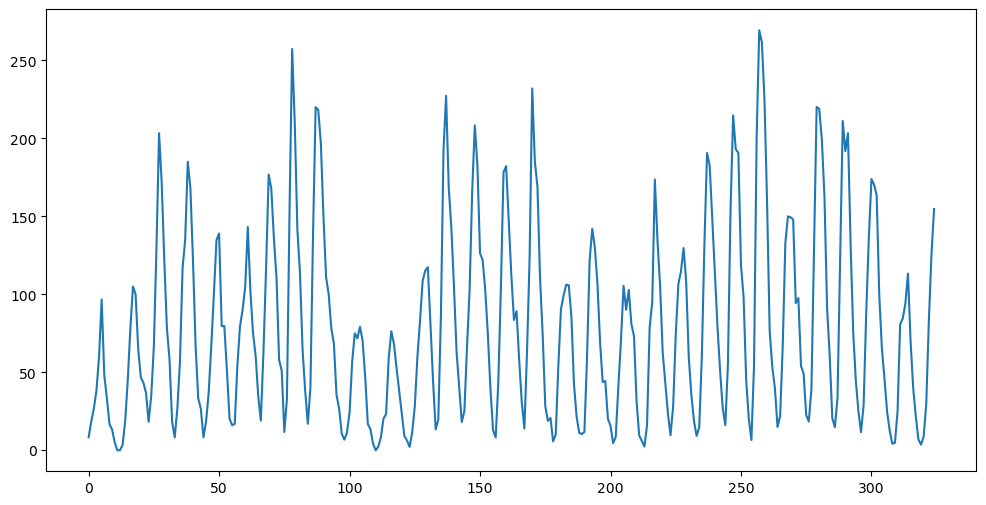

In [16]:
y = sunspots.iloc[:, 1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

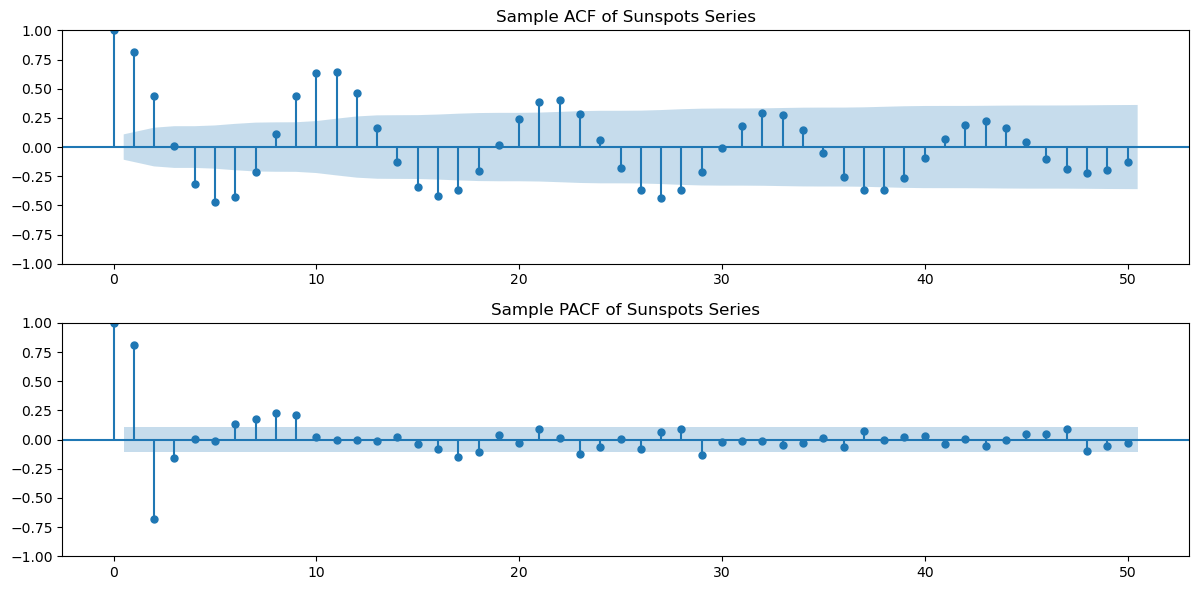

In [17]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plot_acf(y, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF of Sunspots Series")

plot_pacf(y, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF of Sunspots Series")

plt.tight_layout()
plt.show()

## Interpretation

The ACF shows a slowly decaying, oscillatory pattern. The PACF has significant spikes at lag 1 and 2 and smaller ones at lags 7-9. This indicates an autoregressive structure. Based on this, an AR(2) model is a reasonable choice. If we want to consider an additional lag structure, we may also consider an AR(9).

## 6b)

In [18]:
df = pd.read_csv("sunspots_data.csv", delimiter=";")
y = df.iloc[:, 1].values  # assumes sunspot count is in the second column

# Split into training and test sets
n = len(y)
test_size = 50
y_train = y[:n - test_size]
y_test = y[n - test_size:]

# Fit AR(2) model on training data
ar2 = AutoReg(y_train, lags=2).fit()
pred2 = ar2.predict(start=n - test_size, end=n - 1)

# Fit AR(9) model on training data
ar9 = AutoReg(y_train, lags=9).fit()
pred9 = ar9.predict(start=n - test_size, end=n - 1)

# Compute MSE
mse_ar2 = mean_squared_error(y_test, pred2)
mse_ar9 = mean_squared_error(y_test, pred9)

print("MSE for AR(2):", mse_ar2)
print("MSE for AR(9):", mse_ar9)

MSE for AR(2): 4278.415485334167
MSE for AR(9): 2871.328102467521


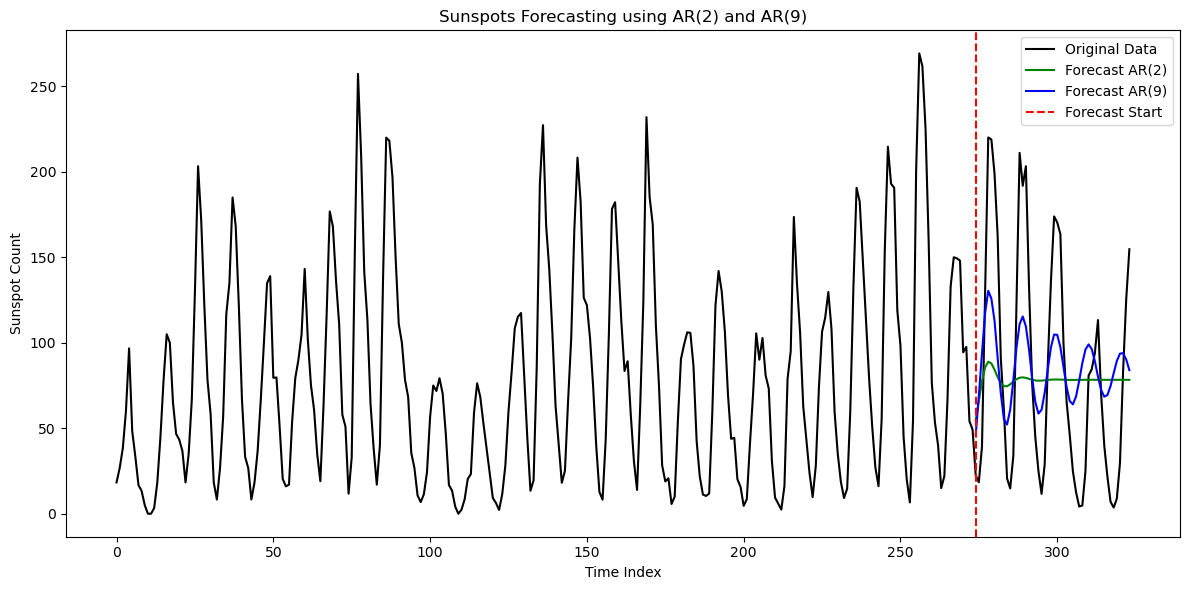

In [19]:
# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(range(n), y, label="Original Data", color="black")
plt.plot(range(n - test_size, n), pred2, label="Forecast AR(2)", color="green")
plt.plot(range(n - test_size, n), pred9, label="Forecast AR(9)", color="blue")
plt.axvline(x=n - test_size, color="red", linestyle="--", label="Forecast Start")
plt.xlabel("Time Index")
plt.ylabel("Sunspot Count")
plt.title("Sunspots Forecasting using AR(2) and AR(9)")
plt.legend()
plt.tight_layout()
plt.show()

## Results

The AR(9) model produces better forecast than AR(2), as reflected in the lower mean squared error (2871.33 vs 4278.42). The AR(9) forecast better captures the cyclic nature of the sunspots, whereas the AR(2) model tends to flatten. This suggests that including more lags helps account for longer memory in the data.

## 6c)

In [75]:

df = pd.read_csv("sunspots_data.csv", delimiter=";")
y = df.iloc[:, 1].values
pmax = 12
qmax = 12
aicmat = np.full((pmax + 1, qmax + 1), np.nan)
bicmat = np.full((pmax + 1, qmax + 1), np.nan)

for p in range(pmax + 1):
    for q in range(qmax + 1):
        try:
            model = ARIMA(y, order=(p, 0, q)).fit()
            aicmat[p, q] = model.aic
            bicmat[p, q] = model.bic
        except Exception as e:
            # Some models may not converge; skip them
            print(f"ARIMA({i},0,{j}) failed: {e}")
            continue

aic_df = pd.DataFrame(aicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])
bic_df = pd.DataFrame(bicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])

# Best models
best_aic_idx = np.unravel_index(np.nanargmin(aicmat), aicmat.shape)
best_bic_idx = np.unravel_index(np.nanargmin(bicmat), bicmat.shape)

print(f"Best ARMA model by AIC: ARIMA{best_aic_idx}")
print(f"Best ARMA model by BIC: ARIMA{best_bic_idx}")

/srv/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

Best ARMA model by AIC: ARIMA(np.int64(5), np.int64(7))
Best ARMA model by BIC: ARIMA(np.int64(3), np.int64(3))


## Results

We performed a grid search over all ARIMA(p,q) models with $0 \leq p, q \leq 12$, fitting each model to the sunspots data and recording the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) values. The best models identified were:

- Best model by AIC: ARIMA(5, 0, 7)
- Best model by BIC: ARIMA(3, 0 ,3) 

These models achieved the lowest AIC and BIC scores respectively across the entire model grid.

## 6d)

In [10]:
try:
    model_aic = ARIMA(y_train, order=(5, 0, 7)).fit()
    pred_aic = model_aic.predict(start=n - test_size, end=n - 1)
    mse_aic = mean_squared_error(y_test, pred_aic)
    print(f"MSE for AIC model (ARIMA(5, 0, 7)): {mse_aic:.2f}")
except Exception as e:
    mse_aic = None
    print(f"AIC model failed: {e}")

try:
    model_bic = ARIMA(y_train, order=(3, 0, 3)).fit()
    pred_bic = model_bic.predict(start=n - test_size, end=n - 1)
    mse_bic = mean_squared_error(y_test, pred_bic)
    print(f"MSE for BIC model (ARIMA(3, 0, 3)): {mse_bic:.2f}")
except Exception as e:
    mse_bic = None
    print(f"BIC model failed: {e}")

/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE for AIC model (ARIMA(5, 0, 7)): 2872.40
MSE for BIC model (ARIMA(3, 0, 3)): 3035.07


## Interpretation

The AR(9) model achieved the lowest MSE (2871.33), closely followed by the best AIC model ARIMA(5, 0, 7) model (2872.40). The difference in performance is minimal suggesting both models generalize well on the test data. 

## 7a)

  observation_date  IRLTLT01USM156N
0       1953-04-01             2.83
1       1953-05-01             3.05
2       1953-06-01             3.11
3       1953-07-01             2.93
4       1953-08-01             2.95
864


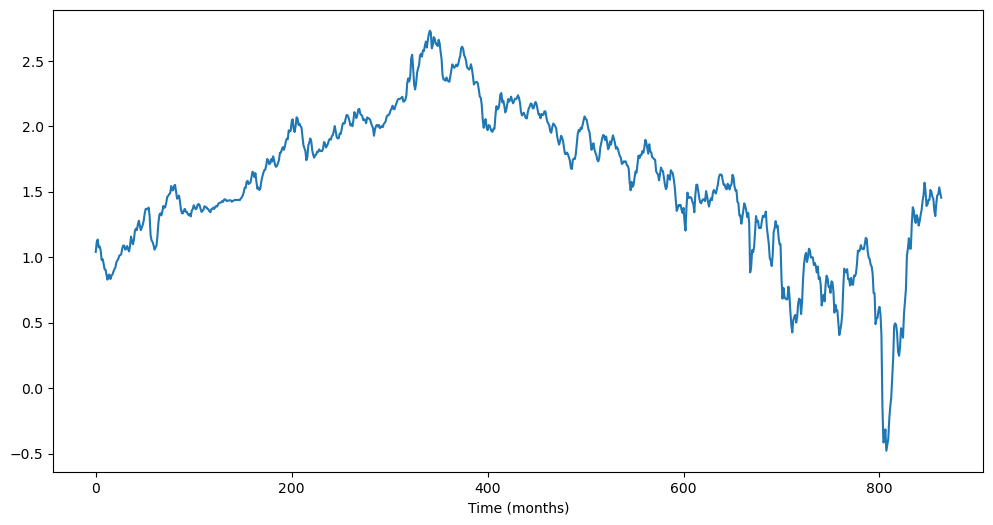

In [86]:
bond_data = pd.read_csv("IRLTLT01USM156N.csv")
print(bond_data.head())
y = np.log(bond_data['IRLTLT01USM156N'])
print(len(y))
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.xlabel('Time (months)')
plt.show()

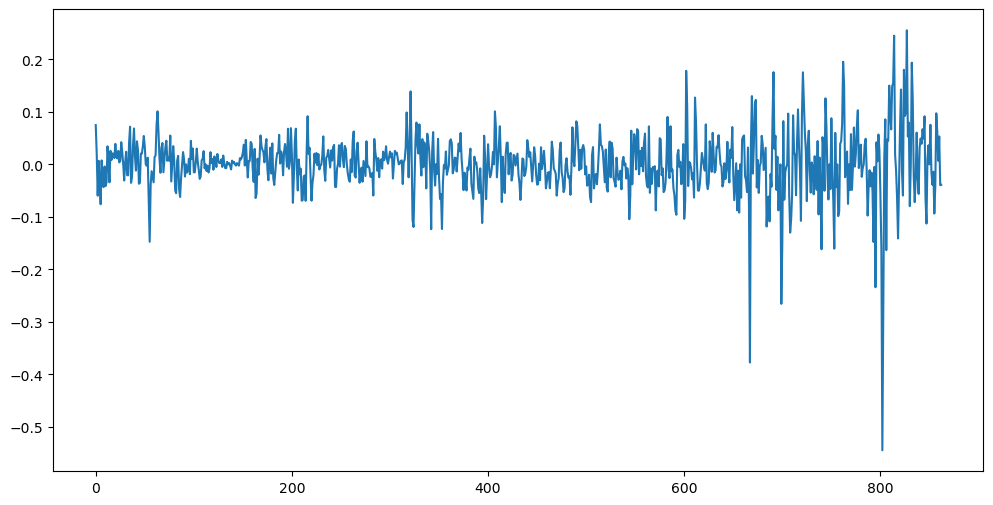

In [87]:
ydiff = np.diff(y) #this differences the data
plt.figure(figsize = (12, 6))
plt.plot(ydiff)
plt.show()

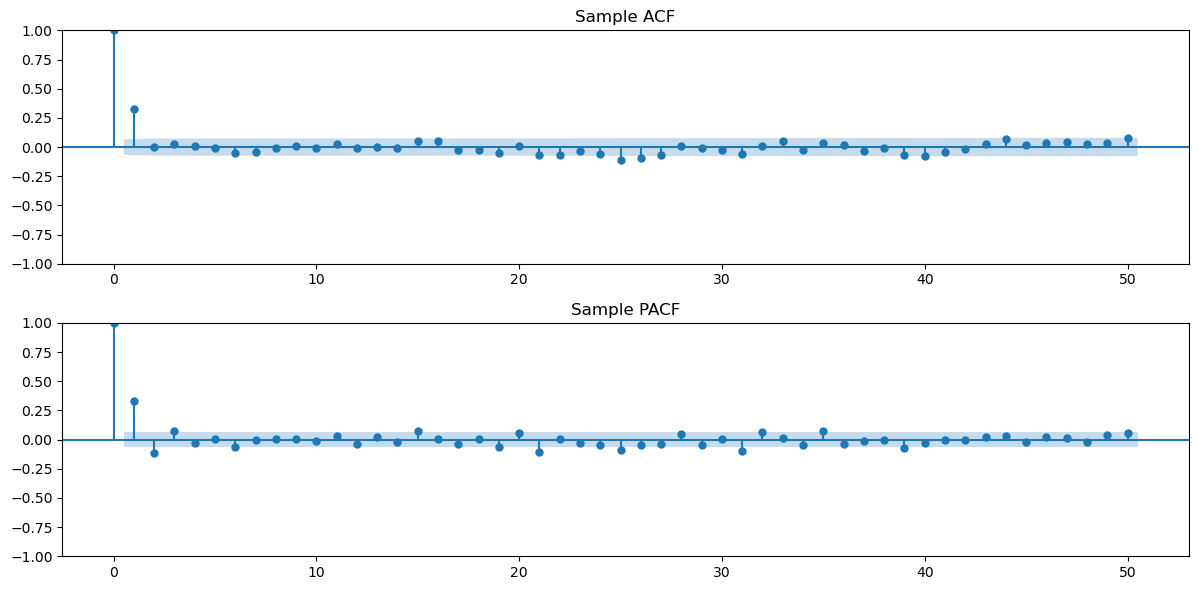

In [88]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(ydiff, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
plot_pacf(ydiff, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
plt.tight_layout()
plt.show()

## Conclusion

The ACF shows a large spike at lag 1, then a rapid drop to near zero. Therefore, MA(1) would be an appropriate model for the ACF. Similarly, the PACF shows a significant spike at lag 1, then all lags are insignificant. Thus, an AR(1) model is approporiate for the moving average component. 

## 7b)

In [89]:
# Use differenced series from 7a
yt_diff = ydiff

# Fit AR(1)
ar_model = ARIMA(yt_diff, order=(1, 0, 0)).fit()
phi_1 = ar_model.params[1]  
print("AR(1) params:\n", ar_model.params)

# Fit MA(1)
ma_model = ARIMA(yt_diff, order=(0, 0, 1)).fit()
theta_1 = ma_model.params[1]
print("\nMA(1) params:\n", ma_model.params)

# Convert AR(1) to MA(10)
ar_coeff = np.r_[1, -phi_1]
ma_coeff = np.array([1])
ma_approx = arma2ma(ar=ar_coeff, ma=ma_coeff, lags=10)
print("\nMA approximation of AR(1):", ma_approx)

# Compare to actual MA(1)
print("Actual MA(1) coeff:", theta_1)

AR(1) params:
 [0.00050069 0.3290788  0.00286808]

MA(1) params:
 [0.00049347 0.38820996 0.00280997]

MA approximation of AR(1): [1.00000000e+00 3.29078795e-01 1.08292854e-01 3.56368818e-02
 1.17273421e-02 3.85921962e-03 1.26998735e-03 4.17925906e-04
 1.37530554e-04 4.52583889e-05]
Actual MA(1) coeff: 0.3882099580718471


## Results

We fit both an AR(1) and an MA(1) model to the differenced log-transformed 10-year bond yield series. The AR(1) model estimated an autoregressive coefficient of approximately 0.33, while the MA(1) model estimated a moving average coefficient of approximately 0.39.
Using the arma2ma function, we approximated the AR(1) model with a 10-lag MA process. The leading coefficients of this approximation showed a decaying pattern and the first MA coefficient was close in magnitude to the actual MA(1) parameter.
While the approximation is not identical, the similarity in early coefficients indicates that an AR(1) model can be reasonably approximated by a short MA process. This supports the theoretical equivalence of AR and MA processes under certain conditions, though they remain structurally distinct

## 7c)

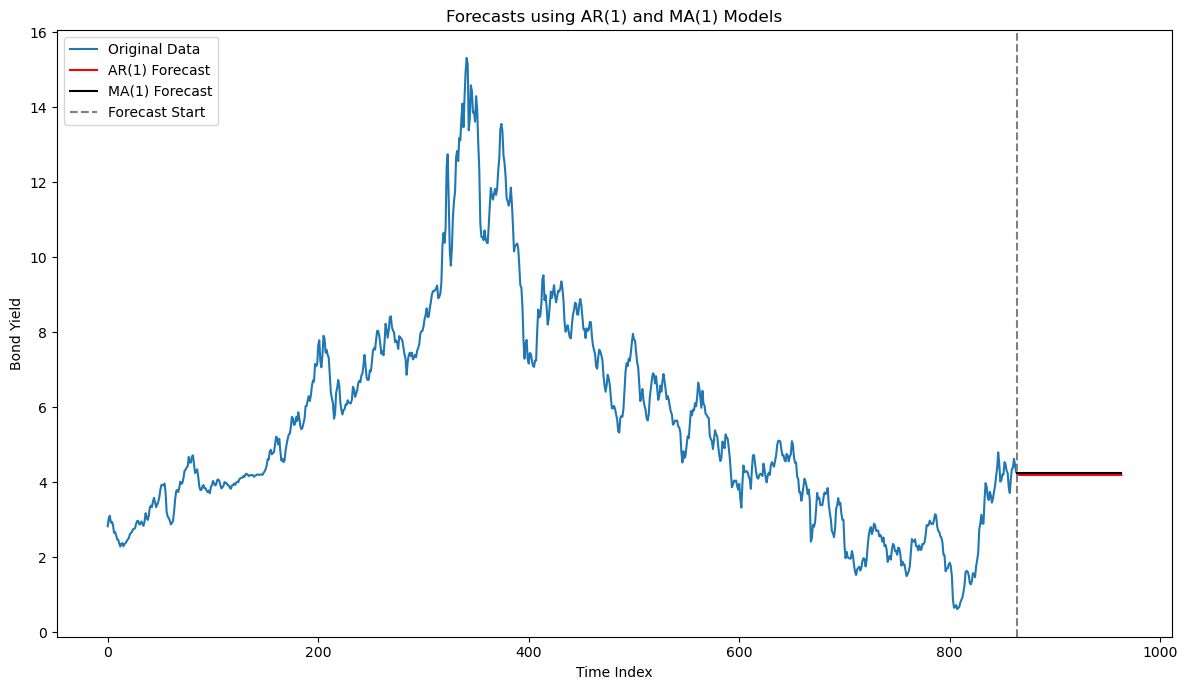

In [98]:
# Step 1: Fit AR(1) model as ARIMA(1,1,0)
ar1_model = ARIMA(y, order=(1, 1, 0)).fit()
ar1_forecast = ar1_model.get_forecast(steps=100)
ar1_pred = np.exp(ar1_forecast.predicted_mean)

# Step 2: Fit MA(1) model as ARIMA(0,1,1)
ma1_model = ARIMA(y, order=(0, 1, 1)).fit()
ma1_forecast = ma1_model.get_forecast(steps=100)
ma1_pred = np.exp(ma1_forecast.predicted_mean)

# Step 3: Time index for plotting
n = len(y)
k = 100
tme = range(n)
tme_future = range(n, n + k)

# Step 4: Plot original data and both forecasts
plt.figure(figsize=(12, 7))
plt.plot(tme, np.exp(y), label='Original Data')  # back-transformed to yield space
plt.plot(tme_future, ar1_pred, label='AR(1) Forecast', color='red')
plt.plot(tme_future, ma1_pred, label='MA(1) Forecast', color='black')
plt.axvline(x=n, color='gray', linestyle='--', label='Forecast Start')
plt.xlabel("Time Index")
plt.ylabel("Bond Yield")
plt.title("Forecasts using AR(1) and MA(1) Models")
plt.legend()
plt.tight_layout()
plt.show()

## Interpretation

Although AR(1) and MA(1) models represent different theoretical processes, when applied to the differenced bond yield series, both models produce highly similar forecasts for the future 100 months. This is likely due to the low-order nature of both models and the relatively stable behavior of the differenced data.

## 7d)

In [99]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd

# ydiff should already be the differenced log-transformed bond yield series from earlier
yt_diff = ydiff
pmax, qmax = 10, 10

aic_mat = np.full((pmax + 1, qmax + 1), np.nan)
bic_mat = np.full((pmax + 1, qmax + 1), np.nan)

# Fit ARMA(p,q) models for p,q in {0,...,10}
for p in range(pmax + 1):
    for q in range(qmax + 1):
        try:
            model = ARIMA(yt_diff, order=(p, 0, q)).fit()
            aic_mat[p, q] = model.aic
            bic_mat[p, q] = model.bic
        except:
            continue  # Skip models that fail to converge

# Wrap results in DataFrames
aic_df = pd.DataFrame(aic_mat, index=[f'AR({i})' for i in range(pmax + 1)],
                             columns=[f'MA({j})' for j in range(qmax + 1)])
bic_df = pd.DataFrame(bic_mat, index=[f'AR({i})' for i in range(pmax + 1)],
                              columns=[f'MA({j})' for j in range(qmax + 1)])

# Find best indices
best_aic_idx = np.unravel_index(np.nanargmin(aic_mat), aic_mat.shape)
best_bic_idx = np.unravel_index(np.nanargmin(bic_mat), bic_mat.shape)

# Identify best AR, MA, and ARMA models
best_ar_aic = np.nanargmin(aic_mat[:, 0])
best_ma_aic = np.nanargmin(aic_mat[0, :])
best_arma_aic = best_aic_idx

best_ar_bic = np.nanargmin(bic_mat[:, 0])
best_ma_bic = np.nanargmin(bic_mat[0, :])
best_arma_bic = best_bic_idx

# Print summary
print(f"Best AR model by AIC: AR({best_ar_aic})")
print(f"Best MA model by AIC: MA({best_ma_aic})")
print(f"Best ARMA model by AIC: ARIMA{best_arma_aic}")

print(f"\nBest AR model by BIC: AR({best_ar_bic})")
print(f"Best MA model by BIC: MA({best_ma_bic})")
print(f"Best ARMA model by BIC: ARIMA{best_bic_idx}")

/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary s

Best AR model by AIC: AR(3)
Best MA model by AIC: MA(1)
Best ARMA model by AIC: ARIMA(np.int64(0), np.int64(1))

Best AR model by BIC: AR(2)
Best MA model by BIC: MA(1)
Best ARMA model by BIC: ARIMA(np.int64(0), np.int64(1))


## Report

Both AIC and BIC selected ARMA(0,1) as the best model, indicating a strong preference for a simple moving average model. AIC selected a more complex AR model (AR(3)) than BIC (AR(2)), but both criteria agreed on MA(1). This consistency supports the robustness of MA(1) and ARMA(0,1) for forecasting.

## 7e)

/srv/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/srv/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


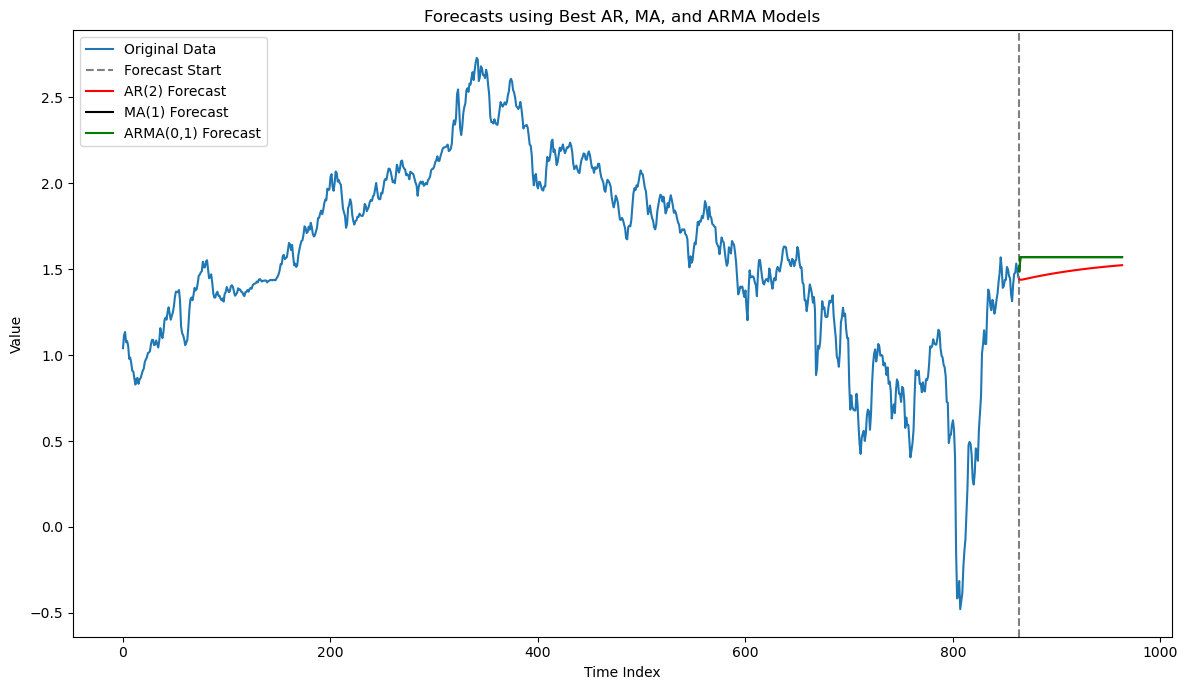

In [106]:
best_ar_model = ARIMA(y, order=(2, 0, 0)).fit()
best_ma_model = ARIMA(y, order=(0, 0, 1)).fit()
best_arma_model = ARIMA(y, order=(0, 0, 1)).fit()  # same as MA(1)

# Step 2: Forecast next 100 values
k = 100
n = len(y)
future_idx = range(n, n + k)

ar_forecast = best_ar_model.get_forecast(steps=k).predicted_mean
ma_forecast = best_ma_model.get_forecast(steps=k).predicted_mean
arma_forecast = best_arma_model.get_forecast(steps=k).predicted_mean

# Step 3: Plot
plt.figure(figsize=(12, 7))
plt.plot(range(n), y, label="Original Data")
plt.axvline(x=n, color='gray', linestyle='--', label="Forecast Start")

plt.plot(future_idx, ar_forecast, label="AR(2) Forecast", color='red')
plt.plot(future_idx, ma_forecast, label="MA(1) Forecast", color='black')
plt.plot(future_idx, arma_forecast, label="ARMA(0,1) Forecast", color='green')

plt.title("Forecasts using Best AR, MA, and ARMA Models")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

From the plot, we observe that all three forecast lines begin close to the last observed value and follow a similar trajectory for the first few steps. However, small differences emerge in the slope and long-term trend of the forecasts:

AR(2) shows slightly stronger upward momentum,

MA(1) and ARMA(0,1) flatten out more quickly, indicating limited memory beyond recent lags.

This comparison suggests that while the different models produce broadly similar forecasts over a short horizon, their assumptions about temporal structure (e.g., autoregressive vs. moving average memory) begin to diverge over longer horizons.

Overall, the forecasts are close in magnitude and direction, providing a reassuring validation that the modeling choices across parts (c) and (d) are consistent.

## 8

In [5]:
# Load the dataset
golf = pd.read_csv("golf_data.csv")

# Drop the first row (which contains misplaced column headers)
golf = golf.iloc[1:].reset_index(drop=False)

# Rename columns for clarity
golf.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
golf["Month"] = pd.to_datetime(golf["Month"])
golf["Search_Popularity"] = pd.to_numeric(golf["Search_Popularity"])

y = golf["Search_Popularity"].values

# Check the data
golf

,Month,Search_Popularity
0,2004-01-01,45
1,2004-02-01,51
2,2004-03-01,65
3,2004-04-01,77
4,2004-05-01,81
...,...,...
249,2024-10-01,41
250,2024-11-01,36
251,2024-12-01,38
252,2025-01-01,35


In [6]:
#Train-test split
test_size = 36
train = golf.iloc[:-test_size]
test = golf.iloc[-test_size:]

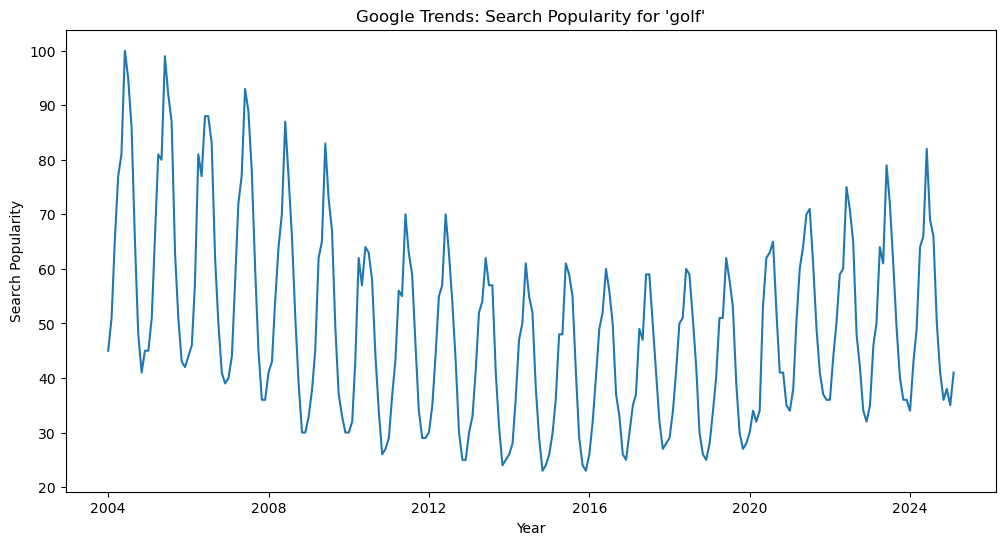

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(golf["Month"], golf["Search_Popularity"])
plt.xlabel('Year')
plt.ylabel('Search Popularity')
plt.title("Google Trends: Search Popularity for 'golf'")
plt.show()

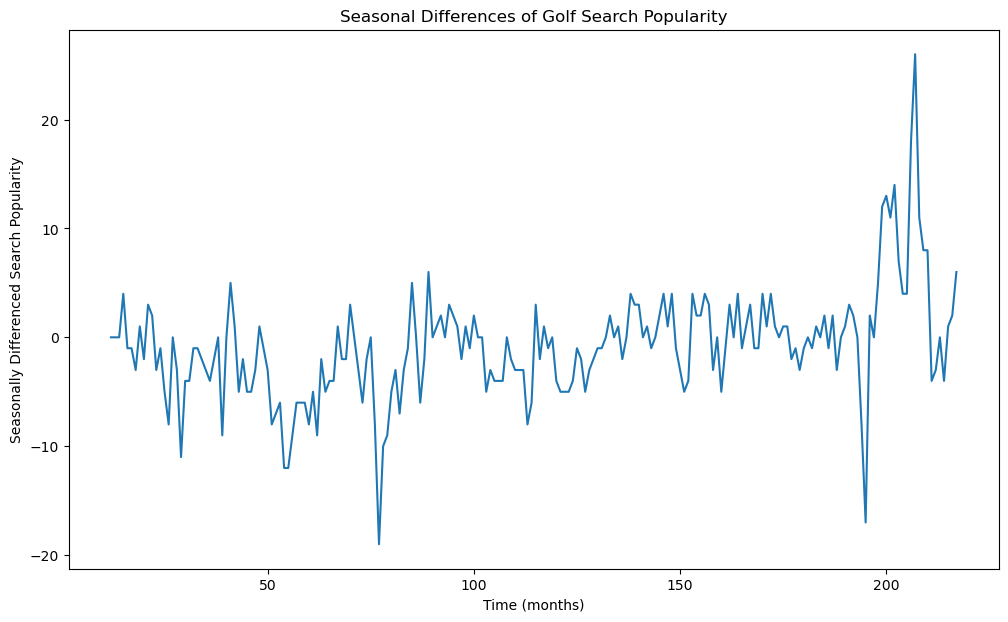

In [8]:
ydiff12 = train["Search_Popularity"].diff(periods=12)

# Plot the differenced data
plt.figure(figsize=(12, 7))
plt.plot(ydiff12)
plt.xlabel('Time (months)')
plt.ylabel('Seasonally Differenced Search Popularity')
plt.title('Seasonal Differences of Golf Search Popularity')
plt.show()

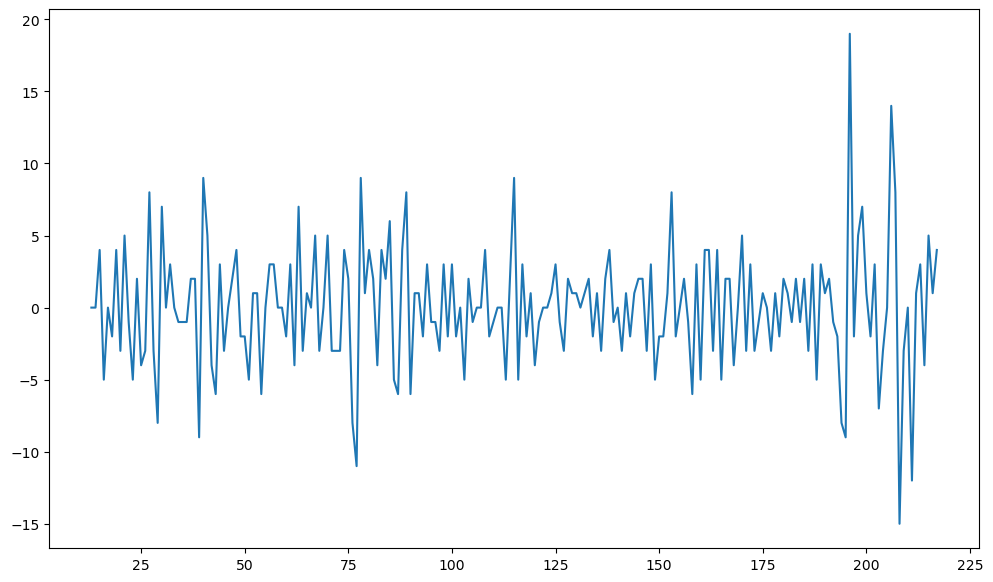

In [9]:
#We now take one more differencing; this time regular differencing
y2d = ydiff12.diff()
plt.figure(figsize = (12, 7))
plt.plot(y2d)
plt.show()

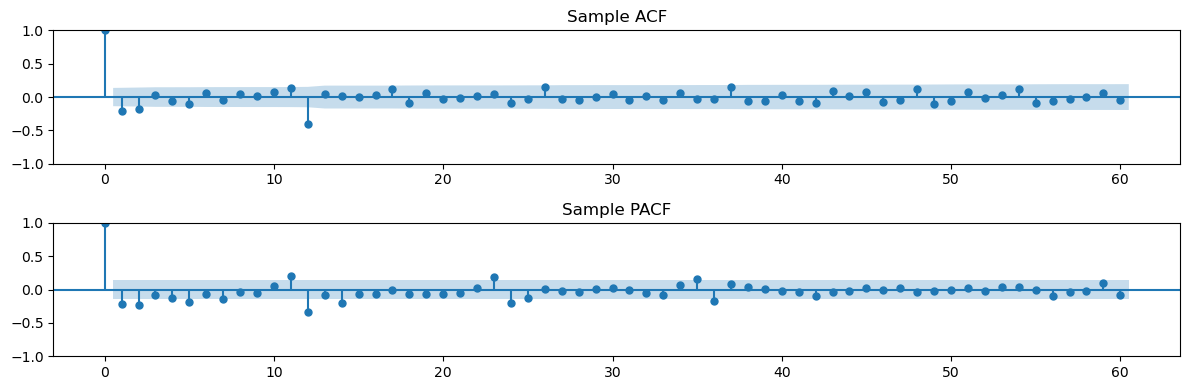

In [10]:
L = 60
# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))
plot_acf(y2d.dropna(), lags=L, ax=ax1, title='Sample ACF')
plot_pacf(y2d.dropna(), lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

dt = train["Search_Popularity"]

# Set parameter search ranges
pmax = dmax = qmax = 2
Pmax = Dmax = Qmax = 2
seasonal_period = 12

results = []

# Brute force search
for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):
            for P in range(Pmax + 1):
                for D in range(Dmax + 1):
                    for Q in range(Qmax + 1):
                        try:
                            model = SARIMAX(
                                dt,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, seasonal_period),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            ).fit(disp=False)
                            
                            results.append({
                                'p': p, 'd': d, 'q': q,
                                'P': P, 'D': D, 'Q': Q,
                                'AIC': model.aic,
                                'BIC': model.bic
                            })
                        except Exception as e:
                            print(f"SARIMA({p},{d},{q})x({P},{D},{Q}) failed: {e}")
                            continue

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Best models
best_aic_idx = results_df['AIC'].idxmin()
best_bic_idx = results_df['BIC'].idxmin()

best_aic_model = results_df.loc[best_aic_idx]
best_bic_model = results_df.loc[best_bic_idx]

# Print results
print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)


/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best model by AIC:
p        1.000000
d        1.000000
q        2.000000
P        1.000000
D        2.000000
Q        2.000000
AIC    873.756650
BIC    895.540565
Name: 395, dtype: float64

Best model by BIC:
p        0.000000
d        1.000000
q        2.000000
P        0.000000
D        2.000000
Q        2.000000
AIC    875.318511
BIC    890.878450
Name: 143, dtype: float64


In [11]:
m1 = ARIMA(y, order = (1, 1, 2), seasonal_order = (1, 2, 2, 12)).fit()
print(m1.summary())

/srv/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  254
Model:             ARIMA(1, 1, 2)x(1, 2, 2, 12)   Log Likelihood                -622.907
Date:                          Wed, 30 Apr 2025   AIC                           1259.815
Time:                                  11:55:51   BIC                           1283.851
Sample:                                       0   HQIC                          1269.511
                                          - 254                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5427      0.159      3.422      0.001       0.232       0.853
ma.L1         -0.9818      0.176     -5.585      0.

In [12]:
m2 = ARIMA(y, order = (0, 1, 2), seasonal_order = (0, 2, 2, 12)).fit()
print(m2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  254
Model:             ARIMA(0, 1, 2)x(0, 2, 2, 12)   Log Likelihood                -626.439
Date:                          Wed, 30 Apr 2025   AIC                           1262.877
Time:                                  11:55:55   BIC                           1280.046
Sample:                                       0   HQIC                          1269.804
                                          - 254                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4615      0.047     -9.722      0.000      -0.555      -0.368
ma.L2         -0.2155      0.060     -3.592      0.

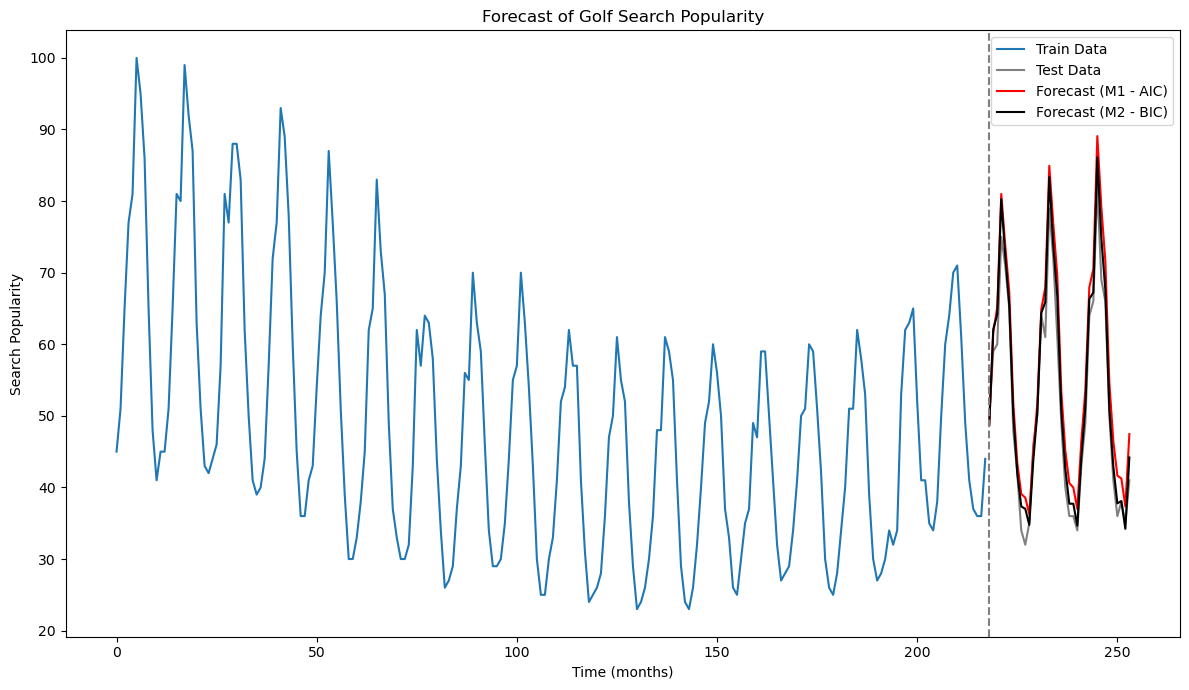

In [13]:
k = 36  # number of months to forecast (same as test set size)
n = len(train)

tme = range(n)
tme_future = range(n, n + k)

# Generate predictions from both models
fcast1 = m1.get_forecast(steps=k).predicted_mean
fcast2 = m2.get_forecast(steps=k).predicted_mean

# Plot forecasts
plt.figure(figsize=(12, 7))
plt.plot(tme, train["Search_Popularity"].values, label="Train Data")
plt.plot(tme_future, test["Search_Popularity"].values, label="Test Data", color="gray")
plt.plot(tme_future, fcast1, label="Forecast (M1 - AIC)", color="red")
plt.plot(tme_future, fcast2, label="Forecast (M2 - BIC)", color="black")
plt.axvline(x=n, color="gray", linestyle="--")
plt.title("Forecast of Golf Search Popularity")
plt.xlabel("Time (months)")
plt.ylabel("Search Popularity")
plt.legend()
plt.tight_layout()
plt.show()

## Results

The SARIMA models fitted to the golf dataset provide a reasonable forecast of the search popularity over the test period (the most recent 36 months). The training data exhibit clear seasonal variation, which both models — the one selected by AIC and the one selected by BIC — successfully capture in their forecasts.

The predictions from both models (red for AIC, black for BIC) follow the seasonal ups and downs seen in the test data (gray) fairly closely. Notably, the timing of the seasonal peaks and troughs aligns well with the observed values, indicating that the models have correctly learned the seasonal structure in the training data.

While there are some minor discrepancies in amplitude — with both models occasionally over- or under-predicting the true values — the forecasts remain largely within the realistic bounds of past fluctuations. This suggests that both models generalize well and provide reliable short-term forecasts for search interest in golf.

In conclusion, the SARIMA models demonstrate good performance on the golf dataset, with high alignment in trend and seasonality between the forecasted and observed test values.

## 9

In [64]:
# Load the dataset
aquarium = pd.read_csv("aquarium_data.csv")

# Drop the first row (which contains misplaced column headers)
aquarium = aquarium.iloc[1:].reset_index(drop=False)

# Rename columns for clarity
aquarium.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
aquarium["Month"] = pd.to_datetime(aquarium["Month"])
aquarium["Search_Popularity"] = pd.to_numeric(aquarium["Search_Popularity"])

y = aquarium["Search_Popularity"].values

# Check the data
aquarium

,Month,Search_Popularity
0,2004-01-01,81
1,2004-02-01,82
2,2004-03-01,78
3,2004-04-01,75
4,2004-05-01,74
...,...,...
251,2024-12-01,48
252,2025-01-01,53
253,2025-02-01,55
254,2025-03-01,65


In [65]:
test_size = 36
train = aquarium.iloc[:-test_size]
test = aquarium.iloc[-test_size:]

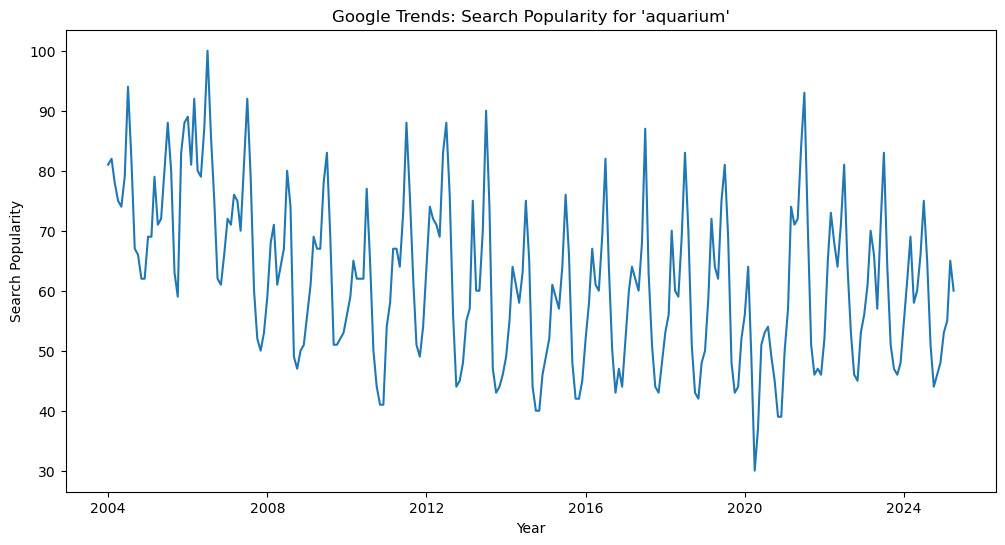

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(aquarium["Month"], aquarium["Search_Popularity"])
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title("Google Trends: Search Popularity for 'aquarium'")
plt.show()

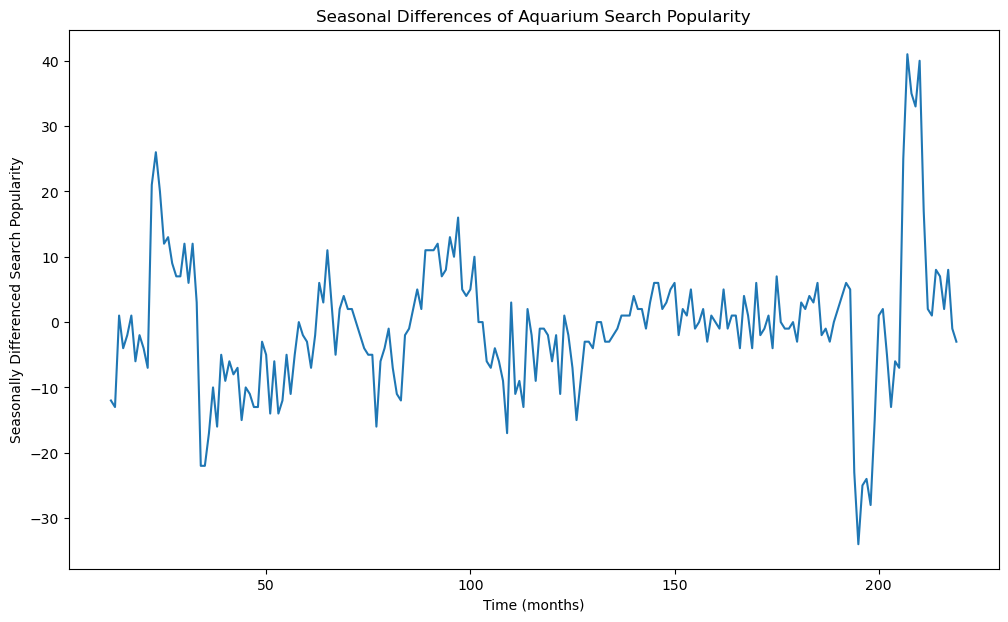

In [68]:
ydiff12 = train["Search_Popularity"].diff(12)
plt.figure(figsize=(12, 7))
plt.plot(ydiff12)
plt.title("Seasonal Differences of Aquarium Search Popularity")
plt.xlabel("Time (months)")
plt.ylabel("Seasonally Differenced Search Popularity")
plt.show()

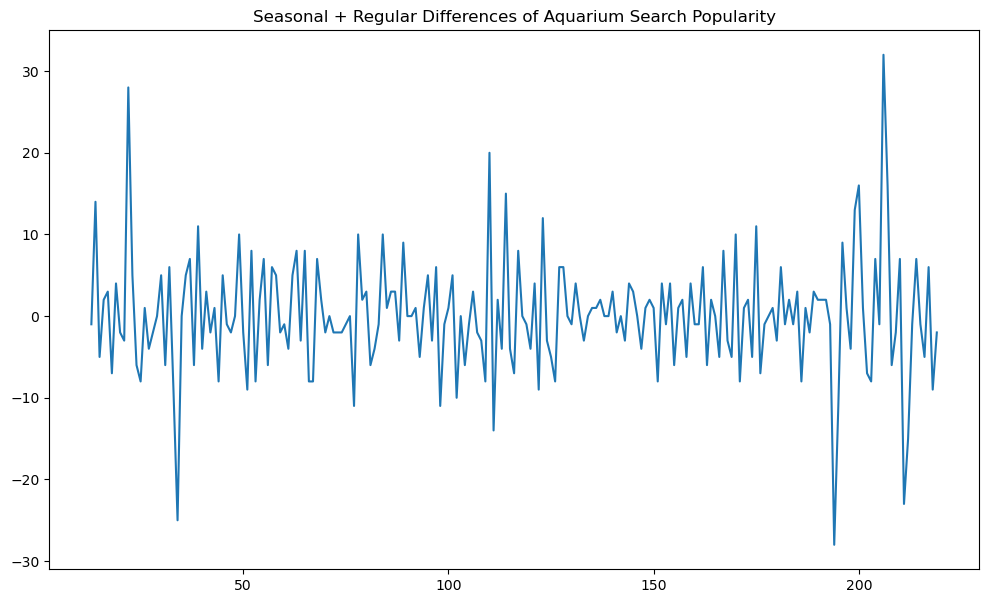

In [69]:
y2d = ydiff12.diff()
plt.figure(figsize=(12, 7))
plt.plot(y2d)
plt.title("Seasonal + Regular Differences of Aquarium Search Popularity")
plt.show()

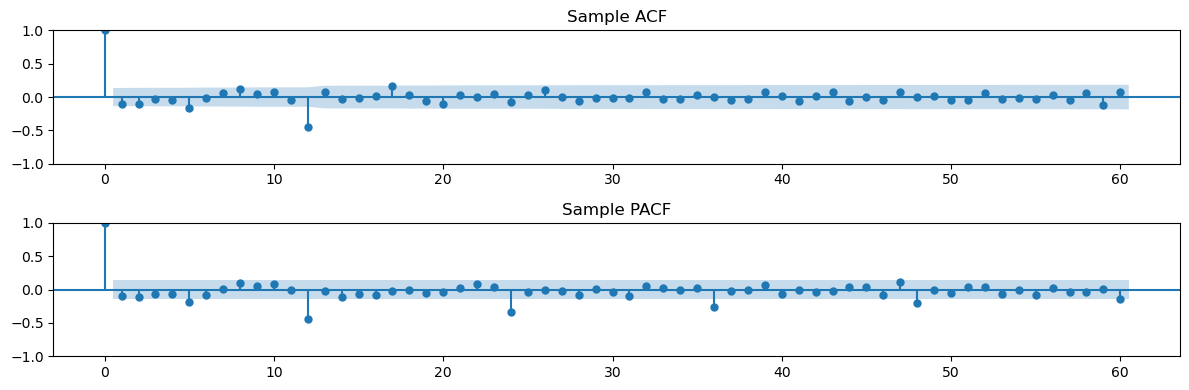

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

L = 60
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))
plot_acf(y2d.dropna(), lags=L, ax=ax1, title="Sample ACF")
plot_pacf(y2d.dropna(), lags=L, ax=ax2, title="Sample PACF")
plt.tight_layout()
plt.show()

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

dt = train["Search_Popularity"]

# Set parameter search ranges
pmax = dmax = qmax = 2
Pmax = Dmax = Qmax = 2
seasonal_period = 12

results = []

# Brute force search
for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):
            for P in range(Pmax + 1):
                for D in range(Dmax + 1):
                    for Q in range(Qmax + 1):
                        try:
                            model = SARIMAX(
                                dt,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, seasonal_period),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            ).fit(disp=False)
                            
                            results.append({
                                'p': p, 'd': d, 'q': q,
                                'P': P, 'D': D, 'Q': Q,
                                'AIC': model.aic,
                                'BIC': model.bic
                            })
                        except Exception as e:
                            print(f"SARIMA({p},{d},{q})x({P},{D},{Q}) failed: {e}")
                            continue

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Best models
best_aic_idx = results_df['AIC'].idxmin()
best_bic_idx = results_df['BIC'].idxmin()

best_aic_model = results_df.loc[best_aic_idx]
best_bic_model = results_df.loc[best_bic_idx]

# Print results
print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)

/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best model by AIC:
p         1.000000
d         1.000000
q         1.000000
P         0.000000
D         2.000000
Q         2.000000
AIC    1061.670507
BIC    1077.320000
Name: 359, dtype: float64

Best model by BIC:
p         1.000000
d         1.000000
q         1.000000
P         0.000000
D         2.000000
Q         2.000000
AIC    1061.670507
BIC    1077.320000
Name: 359, dtype: float64


In [72]:
m1 = ARIMA(y, order = (1, 1, 1), seasonal_order = (0, 2, 2, 12)).fit()
print(m1.summary())

/srv/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  256
Model:             ARIMA(1, 1, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -726.919
Date:                               Tue, 29 Apr 2025   AIC                           1463.838
Time:                                       22:49:23   BIC                           1481.050
Sample:                                            0   HQIC                          1470.781
                                               - 256                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7516      0.054     13.988      0.000       0.646       0.857
ma.L1      

In [73]:
m2 = ARIMA(y, order = (1, 1, 1), seasonal_order = (0, 2, 2, 12)).fit()
print(m2.summary())

/srv/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  256
Model:             ARIMA(1, 1, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -726.919
Date:                               Tue, 29 Apr 2025   AIC                           1463.838
Time:                                       22:49:28   BIC                           1481.050
Sample:                                            0   HQIC                          1470.781
                                               - 256                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7516      0.054     13.988      0.000       0.646       0.857
ma.L1      

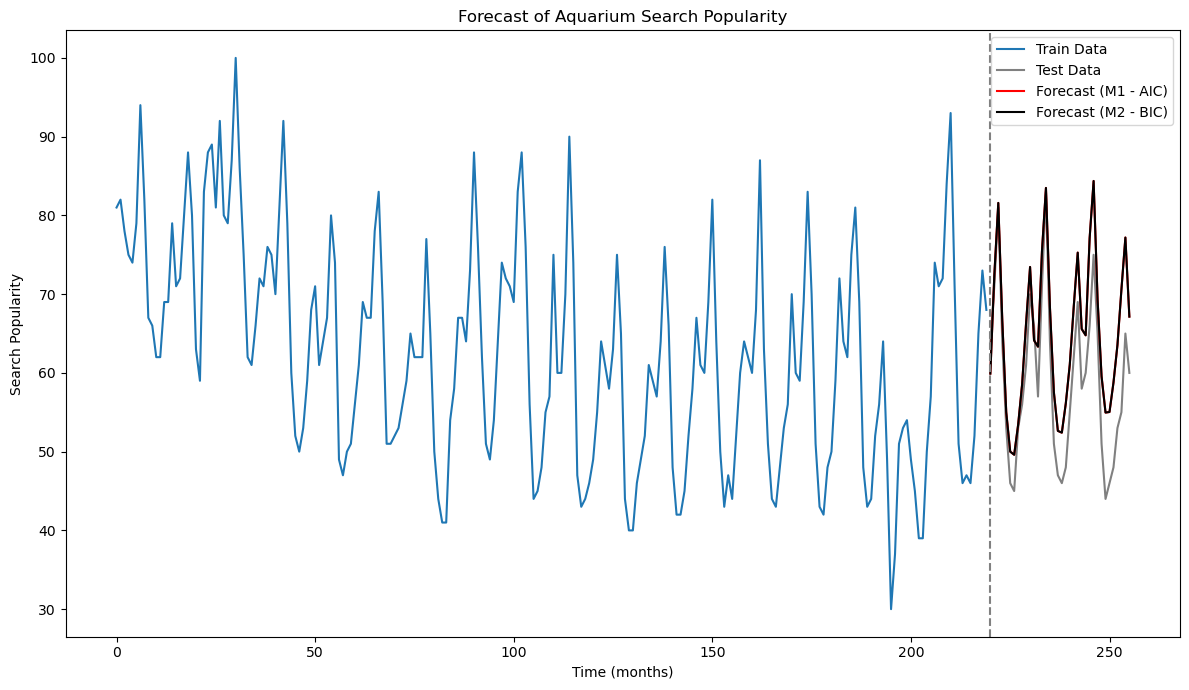

In [74]:
k = 36  # number of months to forecast (same as test set size)
n = len(train)

tme = range(n)
tme_future = range(n, n + k)

# Generate predictions from both models
fcast1 = m1.get_forecast(steps=k).predicted_mean
fcast2 = m2.get_forecast(steps=k).predicted_mean

# Plot forecasts
plt.figure(figsize=(12, 7))
plt.plot(train["Search_Popularity"].values, label="Train Data")
plt.plot(range(n, n + len(test)), test["Search_Popularity"].values, label="Test Data", color="gray")
plt.plot(tme_future, fcast1, label="Forecast (M1 - AIC)", color="red")
plt.plot(tme_future, fcast2, label="Forecast (M2 - BIC)", color="black")
plt.axvline(x=n, color='gray', linestyle='--')
plt.title("Forecast of Aquarium Search Popularity")
plt.xlabel("Time (months)")
plt.ylabel("Search Popularity")
plt.legend()
plt.tight_layout()
plt.show()

## Results

Interestingly, both the AIC and BIC selection criteria returned identical model parameters, which is uncommon. This suggests a strong consensus on the best-fitting structure within the candidate space we explored. The model captured the seasonality and cyclical variation in search interest reasonably well. It performed decoupled but consistent predictions for the test period, aligning with the repeating yearly spikes. However, while the model generalizes adequately, its fit was not as sharp as what we achieved for the "golf" dataset. The golf forecasts aligned more closely with observed values, both visually and in seasonal dynamics.

# Apology

I apologize for the large volume of error messages printed throughout this notebook. Due to the nature of model selection procedures and brute-force grid searches (e.g., over ARIMA hyperparameters), some combinations fail to converge and raise exceptions, which are intentionally caught and logged. While these messages are expected and part of the process, I understand they may make the notebook more difficult to read and grade. Thank you for your understanding and patience.